In [104]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import pandas as pd
from gettingsegments import extract_segments, plot_signal
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from sklearn import preprocessing
from tensorflow import keras

In [105]:
current_dir = os.getcwd()
os.chdir('c:\\Users\\Melanie\\OneDrive - Rensselaer Polytechnic Institute\\Desktop\\School\\24_Spring\\MLE\\Project\\data')

electrode_locations = {"FP1": 0, "FP2": 1, "FC5": 2, "FC6": 3, "FZ": 4,
                        "T7": 5, "CZ": 6, "T8": 7, "P7": 8, "P3": 9, "PZ": 10,
                          "P4": 11, "P8": 12, "O1": 13, "Oz": 14, "O2": 15}

files = os.listdir()
#getting the demographics both gets rid of that column and imports it 
demographics = pd.read_csv(files.pop(0),names=["Isman","Age","Fatigue"])
n = np.shape(demographics)[0]

In [107]:
indices = list(range(10))
def split_data(i, X, y):
    training_set = indices[:i] + indices[i+1:]
    X_train, y_train = X[training_set], np.matrix(y[training_set]).T
    X_test, y_test = X[i], np.matrix(y[i])
    
    #reshape X_test to also be a 3D matrix like how X_train is
    X_test = X_test.reshape(1, np.shape(X_test)[0], np.shape(X_test)[1])
    return X_train, y_train, X_test, y_test

In [108]:
def make_model(inputshape):
    model = Sequential()
    #the layers
    kernal_size = 10
    model.add(Conv1D(filters=64, #this is the number of filters
                    kernel_size=kernal_size,
                    #set the activation function
                    activation='relu', 
                    input_shape = inputshape))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=32, 
                    kernel_size=kernal_size,
                    activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=32, 
                    kernel_size=kernal_size,
                    activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=32, 
                    kernel_size=kernal_size,
                    activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=16, 
                    kernel_size=kernal_size,
                    activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=16, 
                    kernel_size=kernal_size,
                    activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=16, 
                    kernel_size=kernal_size,
                    activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=16, 
                    kernel_size=kernal_size,
                    activation='relu'))

    #flatten out and make the rest of it
    model.add(Flatten())
    model.add(Dense(256, #number of units
                    activation='relu'))
    model.add(Dense(128, #number of units
                    activation='relu'))
    model.add(Dense(64, #number of units
                    activation='relu'))
    model.add(Dense(1, #64 neurons
                    activation='tanh')) #maybe u can try tanh
    #compiler
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    # # Print model summary
    # model.summary()
    return model

In [114]:
def get_model_output(file_value):
    y_predicted = np.zeros(10)
    #get the file
    t, signal, section_num, class_bool, p_num = extract_segments(files[file_value])
    
    #run pca to reduce the dimensionality of the data (whiten to make it N(0,1))
    pca = PCA(whiten = True, n_components = 0.99) #99% seems to be a standard
    new_signal = pca.fit_transform(signal.T).T
    signal = preprocessing.normalize(signal)
    for i in range(10):
        #do some data reshaping and management and splitting
        segments = signal.T.reshape((10,5121,np.shape(signal)[0]))
        y_segments = class_bool.reshape((10, 5121)).T[0]
        y_segments[y_segments == 2] = 0 #get 0s and 1s instead of 1s and 2s
        X_train, y_train, X_test, y_test = split_data(i, segments, y_segments)

        #train the model
        model = make_model(np.shape(segments)[1:])
        history = model.fit(X_train, y_train, 
                            epochs=10, 
                            batch_size=100, 
                            validation_split=0.3,
                            verbose=0)
        y_predicted[i] = round(model.predict(X_test, batch_size=32)[0][0])
    return y_predicted, y_segments

In [110]:
def get_rnn_output(file_value):
    y_predicted = np.zeros(10)
    #get the file
    t, signal, section_num, class_bool, p_num = extract_segments(files[file_value])
    
    #run pca to reduce the dimensionality of the data (whiten to make it N(0,1))
    pca = PCA(whiten = True, n_components = 0.99) #99% seems to be a standard
    new_signal = pca.fit_transform(signal.T).T
    signal = preprocessing.normalize(signal)
    for i in range(10):
        print(i)
        #do some data reshaping and management and splitting
        segments = new_signal.T.reshape((10,5121,np.shape(new_signal)[0]))
        y_segments = class_bool.reshape((10, 5121)).T[0]
        y_segments[y_segments == 2] = 0 #get 0s and 1s instead of 1s and 2s
        X_train, y_train, X_test, y_test = split_data(i, segments, y_segments)
        model = rnn_model()
        history = model.fit(X_train, y_train, 
                            epochs=10, 
                            batch_size=100, 
                            validation_split=0.3,
                            verbose=0)
        print(model.predict(X_test, batch_size=32)[0][0])
        y_predicted[i] = round(model.predict(X_test, batch_size=32)[0][0])
    return y_predicted, y_segments

def rnn_model():
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(60, return_sequences=True, input_shape=[None, 9]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.SimpleRNN(1) # return_sequence=False (univariate time series)
    ])
    
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

In [91]:
t, signal, section_num, class_bool, p_num = extract_segments(files[0]) 
pca = PCA(whiten = True, n_components = 0.99) #99% seems to be a standard
new_signal = pca.fit_transform(signal.3T).T
#do some data reshaping and management and splitting
segments = new_signal.T.reshape((10,5121,np.shape(new_signal)[0]))
y_segments = class_bool.reshape((10, 5121)).T[0]
y_segments[y_segments == 2] = 0 #get 0s and 1s instead of 1s and 2s
X_train, y_train, X_test, y_test = split_data(i, segments, y_segments)

In [69]:
all_predicted_values = np.zeros((len(files)-1,10))
all_actual_values = np.zeros((len(files)-1,10))

In [71]:
predicted_values

array([[1., 0., 1., 1., 1., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1., 1., 0.],
       [1., 0., 1., 0., 1., 1., 0., 0., 0., 1.],
       [1., 1., 0., 1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 1., 1.],
       [1., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 1., 1., 0., 1.],
       [1., 1., 0., 1., 1., 1., 0., 1., 0., 0.],
       [1., 0., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 1., 0., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 1.]])

In [72]:
all_predicted_values.flatten()
all_actual_values.flatten()

array([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0.])

In [130]:
pre_actual = np.array([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0.])
pre_predicted = np.array([[1., 0., 1., 1., 1., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1., 1., 0.],
       [1., 0., 1., 0., 1., 1., 0., 0., 0., 1.],
       [1., 1., 0., 1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 1., 1.],
       [1., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 1., 1., 0., 1.],
       [1., 1., 0., 1., 1., 1., 0., 1., 0., 0.],
       [1., 0., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 1., 0., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 1.]])

In [136]:
np.sum(np.sum(np.reshape(pre_actual,(19,10)) == pre_predicted,axis=1)/19)/10

0.45789473684210524

In [11]:
def get_model_metrics(y_predicted, y_segments, i):
    accuracy = (10 - np.count_nonzero(y_predicted - y_segments))/10
    fig, ax = plt.subplots(figsize=(3,2))
    disp = heatmap(confusion_matrix(y_segments, y_predicted),
               annot = True)
    disp.set_title("Participant {}, acc = {:.2f}".format(i, accuracy))
    plt.show()

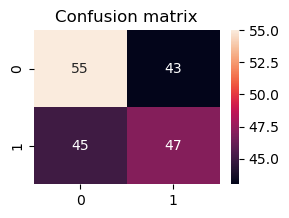

In [73]:
fig, ax = plt.subplots(figsize=(3,2))
disp = heatmap(confusion_matrix(all_predicted_values.flatten(), all_actual_values.flatten()),
            annot = True)
plt.title("Confusion matrix")
plt.show()

In [115]:
i_values = list(range(len(files)))
i_values.pop(6)
all_predicted_values = np.zeros((len(i_values),10))
all_actual_values = np.zeros((len(i_values),10))

for i,v in enumerate(i_values):
    y_predicted, y_segments = get_model_output(i)
    all_predicted_values[i] = y_predicted
    all_actual_values[i] = y_segments

1/1 [==============================] - 0s 405ms/step


In [117]:
np.average(np.sum(all_predicted_values == all_actual_values,axis=1)/10)

0.5111111111111111

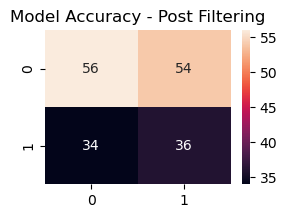

In [119]:
fig, ax = plt.subplots(figsize=(3,2))
disp = heatmap(confusion_matrix(all_predicted_values.flatten(), all_actual_values.flatten()),
            annot = True)
plt.title("Model Accuracy - Post Filtering")
plt.show()